# Skin Cancer Classification

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import tensorflow as tf
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")
image_folder = './data/'

In [2]:
#Avoid out of memory errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

## Data exploratory analysis

In [3]:
! ls

HAM10000_metadata.csv            data
ISIC_0024332.jpg                 logs
Skin_Cancer_classification.ipynb test


In [3]:
metadata = pd.read_csv("HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [11]:
metadata.shape

(10015, 7)

Metadata file store information about the patient and specifies the class:
- akiec --> Bowen's disease
- bcc --> basal cell carcinoma
- bkl --> benign keratosis-like lesions
- df --> dermatofibroma
- mel --> melanoma
- nv --> melanocytic nevi
- vasc --> vascular lesions

In [13]:
metadata.groupby("dx").size()

dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
dtype: int64

Classes are highly unbalanced.

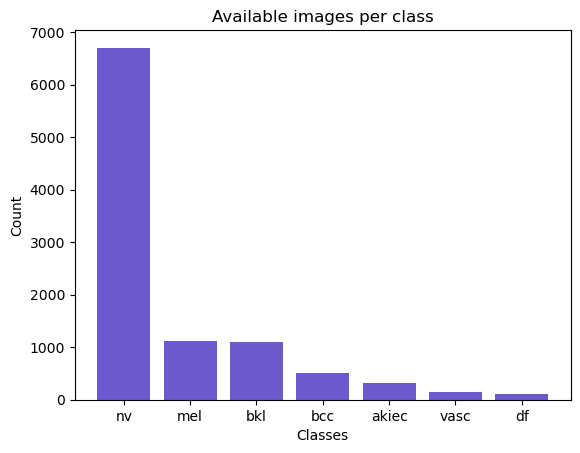

In [87]:
sorted_counts = sorted(metadata.groupby("dx").size().items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_counts)
plt.bar(labels, values, color='slateblue')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Available images per class')
# Show the plot
plt.show()

## Data Preparation

In [4]:
#Dictionary for label conversion
label_map = {key:index for index,key in enumerate(metadata.dx.unique())}
label_map

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

### Cross-validation split

In [5]:
#Perform a stratified split without loading all the images in memory:
#split the folder paths and load them in batches
from sklearn.model_selection import train_test_split


# Create a list of all image paths and their corresponding labels
image_paths = []
labels = []

for class_folder in os.listdir(image_folder):
    class_folder_path = os.path.join(image_folder, class_folder)
    if os.path.isdir(class_folder_path):
        for image_filename in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_filename)
            image_paths.append(image_path)
            labels.append(class_folder)


# Perform stratified split 7-2-1 ratio for train-val-test
train_image_paths, temp_image_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=12345
)

val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    temp_image_paths, temp_labels, test_size=0.33, stratify=temp_labels, random_state=12345
)

In [6]:
# Check class distribution in the original data
original_distribution = metadata['dx'].value_counts(normalize=True)

# Check class distribution in the new sets
train_distribution = pd.Series(train_labels).value_counts(normalize=True)
val_distribution = pd.Series(val_labels).value_counts(normalize=True)
test_distribution = pd.Series(test_labels).value_counts(normalize=True)

print("Original Distribution:")
print(original_distribution)
print("\nTraining Set Distribution:")
print(train_distribution)
print("\nValidation Set Distribution:")
print(val_distribution)
print("\nTest Set Distribution:")
print(test_distribution)

Original Distribution:
dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: proportion, dtype: float64

Training Set Distribution:
nv       0.669472
mel      0.111127
bkl      0.109700
bcc      0.051355
akiec    0.032668
vasc     0.014123
df       0.011555
Name: proportion, dtype: float64

Validation Set Distribution:
nv       0.669647
mel      0.111277
bkl      0.109786
bcc      0.051167
akiec    0.032290
vasc     0.014406
df       0.011426
Name: proportion, dtype: float64

Test Set Distribution:
nv       0.669355
mel      0.110887
bkl      0.109879
bcc      0.051411
akiec    0.033266
vasc     0.014113
df       0.011089
Name: proportion, dtype: float64


Distribution and split correctly mainteined the original class ratio.

### Data augmentation

Since classes are unbalanced, I decided to perform data augmentation on the less represented classes (with less than 1000 images).

In [7]:
#Augment only the training data, and only the low represented classes
img_list = metadata[['image_id','dx']]
augment_classes = img_list.groupby("dx").size()
augment_classes = list(augment_classes[augment_classes < 1000].index)
augment_classes

['akiec', 'bcc', 'df', 'vasc']

I have built an Augmenter object, which creates n modified images from each image in the selected classes.

The applied modifications are:
- Rotation --> randomly between -90 and 90 degrees
- Flip --> with a 50% probability
- Blur --> addition of random intensity of gaussian blur
- Contrast --> random contrast between 0.4 (darker) and 1.4 (lighter)

The augmentation is process is completely reproducible thanks to seeds.

Augmentation is performed only on the training dataset.

In [8]:

class Augmenter():
    @staticmethod
    def modifications(augmented_image,seed):
        random.seed(seed)
        #ROTATE
        rotation_angle = random.uniform(-90, 90)  # Random rotation angle between -90 and 90 degrees
        rotation_matrix = cv2.getRotationMatrix2D((augmented_image.shape[1] / 2, augmented_image.shape[0] / 2), rotation_angle, 1)
        augmented_image = cv2.warpAffine(augmented_image, rotation_matrix, (augmented_image.shape[1], augmented_image.shape[0]))

        #FLIP
        flip_level = random.uniform(0, 1)  # Flip horizontally with 50% probability
        if random.random() < flip_level:
            augmented_image = cv2.flip(augmented_image, 1) 

        #BLUR
        blur_level = random.randint(1, 6) * 2 + 1
        augmented_image = cv2.GaussianBlur(augmented_image, (blur_level, blur_level), 0)

        #CONTRAST
        contrast_factor = np.random.uniform(0.4, 1.4)
        augmented_image = cv2.addWeighted(augmented_image, contrast_factor, np.zeros_like(augmented_image), 0, 0)

        return augmented_image

    @classmethod
    def data_augmentation(cls,image_paths,labels,augment_classes,image_folder,img_list):
        augmentation_factor = 3  # creating n augmented images per original 
        new_images = []
        new_labels = []
        random.seed(12345) #main seed

        for path, label in tqdm(zip(image_paths,labels),desc='Augmenting images'):
            if label in augment_classes:
                class_dir = os.path.join(image_folder,label)
                og_image = cv2.imread(path)
                og_image = cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB)
                #A seed is generated for each image
                seeds = random.sample(range(0, 10000), augmentation_factor)

                for i in range(augmentation_factor):
                    augmented_image = cls.modifications(og_image.copy(),seeds[i])
                    augmented_image_name = f"{os.path.basename(path).split('.')[0]}_aug_{i}.jpg"
                    augmented_image_path = os.path.join(class_dir, augmented_image_name)
                    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
                    cv2.imwrite(augmented_image_path, augmented_image)

                    #new images are stored in the class folder, and added to the training lists

                    new_images.append(augmented_image_path)
                    new_labels.append(label)
                    
                    #It also modifies the metadata, but it's not necessary
                    img_list.loc[len(img_list)] = {'image_id':augmented_image_name.split('.')[0],'dx':label}
                    img_list.reset_index(drop=True, inplace=True)
        
        image_paths.extend(new_images)
        labels.extend(new_labels)


        return image_paths, labels, img_list

In [9]:
augmenter = Augmenter()
train_image_paths,train_labels,img_list = augmenter.data_augmentation(train_image_paths,train_labels, augment_classes, image_folder, img_list)

Augmenting images: 7010it [00:06, 1155.88it/s]


This is an example of augmented image:

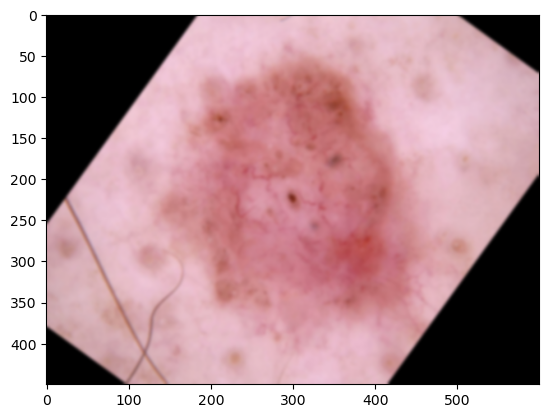

In [24]:
img = cv2.imread('./ISIC_0024332.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

seeds = random.sample(range(0, 10000), 2)

aug = augmenter.modifications(img,seeds[0])
plt.imshow(aug)

In [50]:
img_list.groupby("dx").size()
#Dataset is still unbalanced, mostly for vascular and dermatofibroma, but as I do not want to introduce too much redundance within dataset I stop here.
#Potential improvements could me made using a GAN for image generation.

dx
akiec    1014
bcc      1594
bkl      1099
df        358
mel      1113
nv       6705
vasc      439
dtype: int64

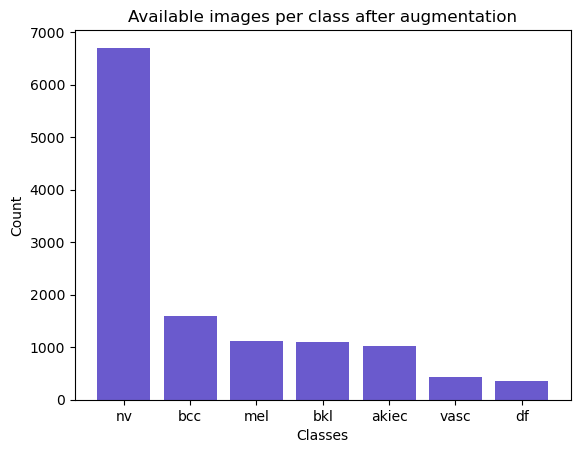

In [88]:
sorted_counts = sorted(img_list.groupby("dx").size().items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_counts)
plt.bar(labels, values, color='slateblue')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Available images per class after augmentation')
# Show the plot
plt.show()

### Data loading

In [26]:
#Convert label in numbers
train_labels = [label_map[x] for x in train_labels]
val_labels = [label_map[x] for x in val_labels]
test_labels = [label_map[x] for x in test_labels]

In [27]:
import pickle
#Store the list of training entries (including the augmented ones)
with open('aug_train_paths.pkl', 'wb') as file:
    pickle.dump(train_image_paths, file)
    #train_image_paths = pickle.load(file)

with open('aug_train_labels.pkl', 'wb') as file:
    pickle.dump(train_labels, file)
    #train_labels = pickle.load(file)

To avoid too much memory consumption, I load the images in batches of 32 using the tensorflow Dataset object.

In [28]:
from sklearn.preprocessing import LabelEncoder

def load_image(image_path,label):
    # Load the raw data from the file
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img/255.0    #scaling image values; new range is 0 to 1
    label = tf.one_hot(label,7) #labels are converted to one hot encoded vectors i.e. 2 --> [0,0,1,0,0,0,0]

    return img,label


def dataset_create(img_paths,labels):
    # Create a dataset from the list of image paths
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))

    #Shuffle the dataset
    buffer_size = len(img_paths)
    dataset = dataset.shuffle(buffer_size,seed=12345)

    # Map the load_and_preprocess_image function to load and preprocess each image
    dataset = dataset.map(load_image)
    
    # Batch the dataset
    batch_size = 32
    dataset = dataset.batch(batch_size)

    return dataset

In [29]:
#Create the final train-val-test data
train = dataset_create(train_image_paths,train_labels)
val = dataset_create(val_image_paths,val_labels)
test = dataset_create(test_image_paths,test_labels)

In [30]:
data_iterator = train.as_numpy_iterator()
#example visualization
batch = data_iterator.next()
batch[0].shape

2023-12-19 13:18:09.146616: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 256, 256, 3)

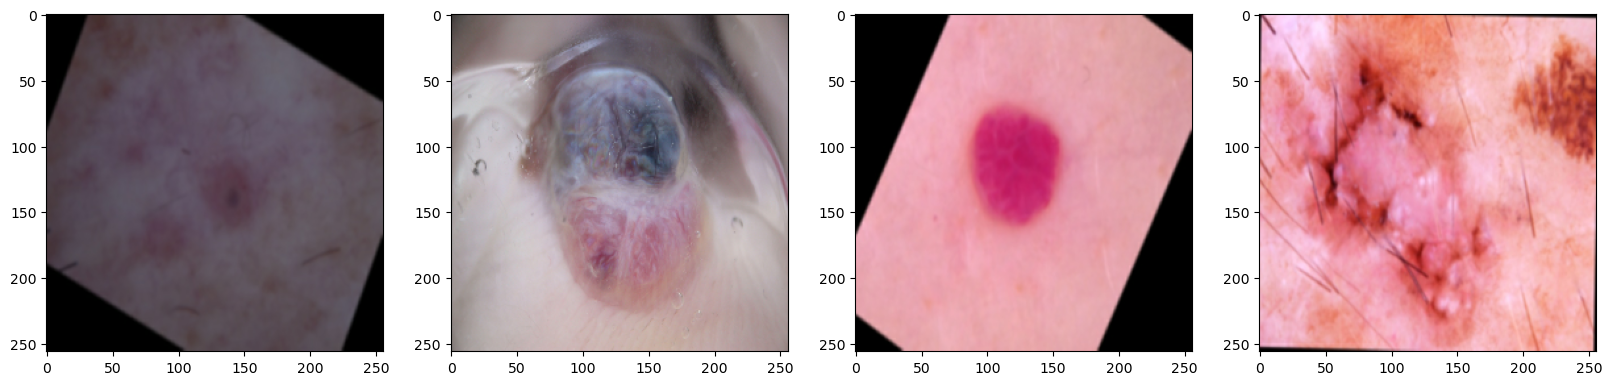

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    

## Network Training

Researching into literature I have found a transfer learning benchmark on this dataset. Apparently DenseNet121 is the most efficient network for this task.

In [81]:
from keras.callbacks import LearningRateScheduler
import math

# Define the learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001 
    decay_factor = 0.7 
    lr = initial_lr * math.pow(decay_factor, epoch)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Flatten,Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet121


early_stopping_monitor = EarlyStopping(patience=3,monitor='val_accuracy')
model_checkpoint_callback = ModelCheckpoint(filepath='skincancer_classifier.h5',
                                            save_weights_only=False,
                                            monitor='val_accuracy',
                                            mode='auto',
                                            save_best_only=True,
                                            verbose=1)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers[:149]:
    layer.trainable = False
for layer in base_model.layers[149:]:
    layer.trainable = True

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
hist = model.fit(train,validation_data=val, batch_size=128,epochs=30, callbacks=[early_stopping_monitor, lr_scheduler, model_checkpoint_callback])
#lr 0.001; lr drop 0.7

Epoch 1/30
292/292 [==============================] - ETA: 0s - loss: 1.1972 - accuracy: 0.5914
Epoch 1: val_accuracy improved from -inf to 0.69001, saving model to model.h5
292/292 [==============================] - 382s 1s/step - loss: 1.1972 - accuracy: 0.5914 - val_loss: 1.1240 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 2/30
292/292 [==============================] - ETA: 0s - loss: 0.8356 - accuracy: 0.6911
Epoch 2: val_accuracy improved from 0.69001 to 0.76006, saving model to model.h5
292/292 [==============================] - 246s 843ms/step - loss: 0.8356 - accuracy: 0.6911 - val_loss: 0.6733 - val_accuracy: 0.7601 - lr: 7.0000e-04
Epoch 3/30
292/292 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7428
Epoch 3: val_accuracy did not improve from 0.76006
292/292 [==============================] - 217s 742ms/step - loss: 0.7137 - accuracy: 0.7428 - val_loss: 0.7101 - val_accuracy: 0.7372 - lr: 4.9000e-04
Epoch 4/30
292/292 [==============================] -

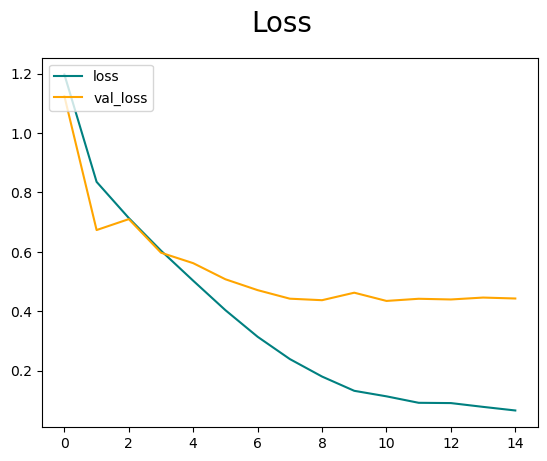

In [67]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

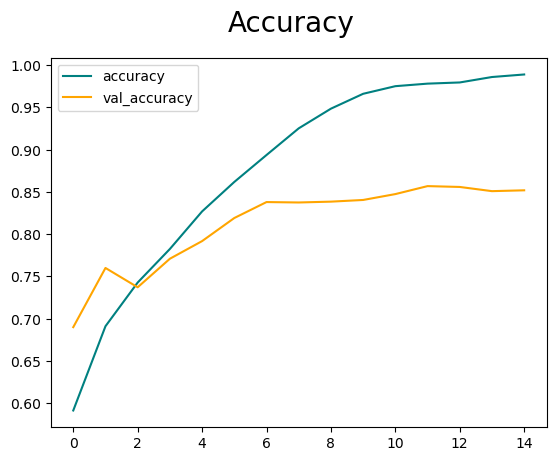

In [68]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Testing

In [70]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test)

# Print the test set loss and accuracy
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

31/31 [==============================] - 11s 343ms/step - loss: 0.4362 - accuracy: 0.8619
Test Loss: 0.4362
Test Accuracy: 86.19%


In [84]:
from keras.models import load_model

best_model = load_model('skincancer_classifier.h5')

# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(test)

# Print the test set loss and accuracy
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

31/31 [==============================] - 38s 765ms/step - loss: 0.4413 - accuracy: 0.8599
Test Loss: 0.4413
Test Accuracy: 85.99%


In [ ]:
#model.save('skincancer_classifier.h5')